## import hazard data and plot, check

In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox

In [2]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [3]:
cd /home/op/network_manila

/home/op/network_manila


In [4]:
#import hazard data

liquefaction = gpd.read_file(r"hazard_data/Liquefaction/Liquefaction_MetroManila.shp")
faultline = gpd.read_file(r"hazard_data/ActiveFault/ActiveFault_MetroManila.shp")

In [5]:
liquefaction.crs, faultline.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

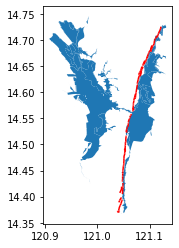

In [6]:
base=liquefaction.plot()
faultline.plot(ax=base, color='red')

In [7]:
#buffer around faultline (50 meters)

faultline["geometry_buffer50"] = faultline.geometry
faultline = faultline.set_geometry("geometry_buffer50")
faultline = faultline.to_crs(crs_manila)
faultline["geometry_buffer50"] = faultline.geometry.buffer(50)
faultline = faultline.to_crs(crs_global)


In [8]:
#import asset data

schools = gpd.read_file(r"asset_data/MetroManila/MetroManila/DepEd/SchoolLocation.shp")
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")

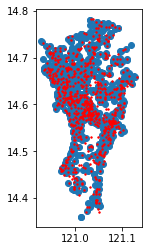

In [9]:
base=schools.plot()
hospitals.plot(ax=base, color='red', markersize=2)

In [10]:
len(schools), len(hospitals), schools.crs, hospitals.crs

(768, 734, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [13]:
G.graph.update( {'crs' : crs_global} )
G.graph.update( {'name' : 'manila'} )

NameError: name 'G' is not defined

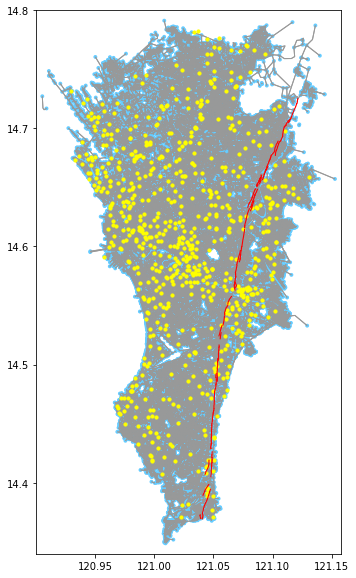

<Figure size 432x288 with 0 Axes>

In [164]:
fig, ax = ox.plot_graph(G, fig_height=10, axis_off=False, show=False)
faultline.plot(ax=ax, color='red', zorder=3)
hospitals.plot(ax=ax, color='yellow', markersize=10, zorder=2)
fig

## disrupt network with hazard data

In [11]:
import shapely
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point


In [12]:
G_clip = nx.read_gpickle('data_osm_raw/manila_clean_clipped.pickle')

In [13]:
def tag_nodes_intersecting_gdf(G, gdf, property_name = 'intersects_gdf'):
    """
    this function tags each node of the graph which lies within the passed geodataframe's polygon
    note that graph and gdf must be in the same crs!
    :param G: a graph containing one or more nodes
    :param gdf: a geodataframe
    :param property_name: a property name for whether the node intersects the gdf
    :returns: a graph
    """

    G_copy = G.copy()
    
    if type(G_copy) == nx.classes.multidigraph.MultiDiGraph or type(G_copy) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')

    # generate dictionary of {node ID: point} pairs
    try:
        list_of_nodes = {}
        for u, data in G_copy.nodes(data=True):
            list_of_nodes.update({u:(data['x'], data['y'])})
    except:
        raise ValueError('loading point geometry went wrong. Ensure node data dict includes x, y values!')

    # get gdf geometry
    try:
        gdf_geometry = gdf.unary_union
    except:
        raise ValueError('Expecting a geodataframe!')

    # create list of values, throw out nodes that don't intersect the gdf
    selKeys = []
    selPts = []
    for key, pt in list_of_nodes.items():
        if Point(pt[0], pt[1]).intersects(gdf_geometry):
            selPts.append(1)
            selKeys.append(key)

    # generate new dictionary of {node ID: 1 where 1 signals intersection}
    ref = dict(zip(selKeys, selPts))

    # load new values onto node data dictionary, set to 0 if not intersecting
    missedCnt = 0
    for u, data in G_copy.nodes(data=True):
        try:
            data[property_name] = ref[u]
        except:
            data[property_name] = 0
            missedCnt += 1
    print("Number of original nodes:", len(G_copy.nodes))
    print("Number of missed nodes gdf:", missedCnt)
    print("Number of nodes that intersect gdf:", len(selKeys))

    return G_copy

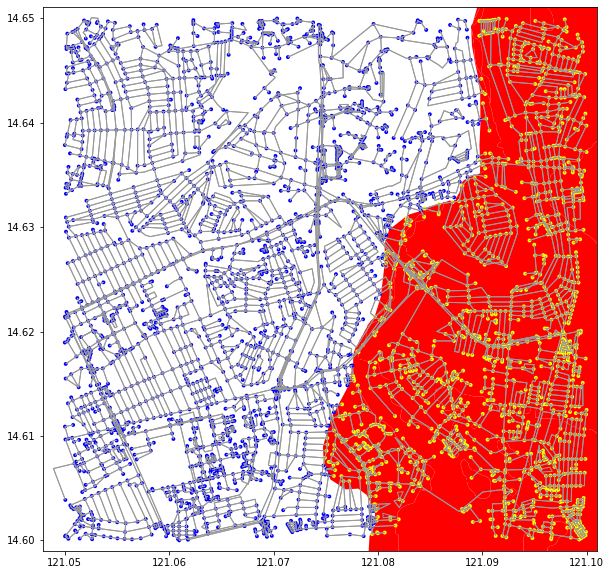

<Figure size 432x288 with 0 Axes>

In [18]:
G_liq.graph.update( {'crs' : crs_global} )
G_liq.graph.update( {'name' : 'manila'} )
nc = ['yellow' if data['intersects_liquefaction']==1 else 'blue' for u, data in G_liq.nodes(data=True)]
fig, ax = ox.plot_graph(G_liq, fig_height=10, axis_off=False, show=False, node_color=nc)
liquefaction.plot(ax=ax, color='red', zorder=0)
fig

In [23]:
def tag_edges_intersecting_polygons(G, gdf, geometry_tag = "Wkt", xCol='x', yCol = 'y', 
                                    new_property_name = 'intersects_gdf' ):
    """
    Function for tagging edges of a graph that intersect polygon(s).
    !! Ensure Graph G and GeoDataFrame gdf are in the same projection before using function !!

    :param G: a Graph object
    :param gdf: a GeoDataFrame containing one or more polygons
    :param geometry_tag: the name of the Graph's edges' attribute holdings the geometry, if available
    :param xCol: if no shapely geometry but Longitude present, assign here
    :param yCol: if no shapely geometry but Latitude present, assign here
    :param new_property_name: the name of the edge property in the returned graph, containing 1 if edge intersects
            GDF and 0 if it does not
    :returns: the graph with edges intersecting polygons tagged with new_property_name = 1
    """
   
    G_copy = G.copy()
    
    if type(G_copy) == nx.classes.multidigraph.MultiDiGraph or type(G_copy) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph for parameter G!')
       
    # get gdf geometry
    try:
        gdf_geometry = gdf.unary_union
    except:
        raise ValueError('Expecting a geodataframe for parameter gdf!')

    #collect stats
    edges_intersecting = 0
    edges_not_intersecting = 0
    
    #iterate through all edges of graph
    for u, v, data in G_copy.edges(data=True):
              
        # get geometry of node (and construct straight line if there is none)
        if geometry_tag in data:
            #if the geometry tag is Wkt we first have to load the geometry into shapely
            if geometry_tag == "Wkt":
                geom = loads(data[geometry_tag])
            #if there is already a geometry attribute, we can just use it
            else:
                geom = data[geometry_tag]
        else:
            # if it doesn't have a geometry attribute, we assume the edge is a straight
            # line from node to node
            x1 = G.nodes[u][xCol]
            y1 = G.nodes[u][yCol]
            x2 = G.nodes[v][xCol]
            y2 = G.nodes[v][yCol]
            geom = LineString([(x1, y1), (x2, y2)])
    
    
        #tag the edges that intersect the gdf with 1, and those that don't with a zero
        if geom.intersects(gdf_geometry) == True:
            data[new_property_name] = 1
            edges_intersecting += 1
        else:
            data[new_property_name] = 0
            edges_not_intersecting += 1
            
    print("Number of original edges:", len(G_copy.edges))
    print("Number of edges that intersect gdf:", edges_intersecting)
    print("Number of edges that don't intersect gdf:", edges_not_intersecting)

    
    return G_copy
    

In [33]:
G_clip_liq = tag_edges_intersecting_polygons(G_clip, gdf = liquefaction, geometry_tag = "Wkt", 
                                    new_property_name = 'intersects_liquefaction')

Number of original edges: 11367
Number of edges that intersect gdf: 4114
Number of edges that don't intersect gdf: 7253


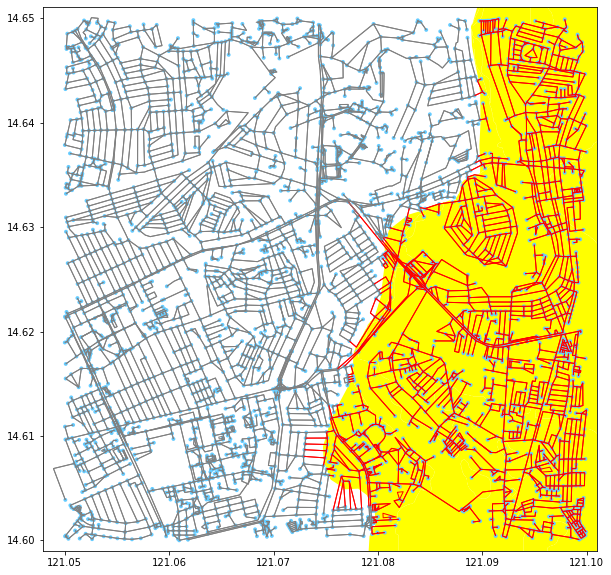

<Figure size 432x288 with 0 Axes>

In [34]:
G_clip_liq.graph.update( {'crs' : crs_global} )
G_clip_liq.graph.update( {'name' : 'manila'} )
nc = ['red' if data['intersects_liquefaction']==1 else 'grey' for u, v, data in G_clip_liq.edges(data=True)]
fig, ax = ox.plot_graph(G_clip_liq, fig_height=10, axis_off=False, show=False, edge_color=nc)
liquefaction.plot(ax=ax, color='yellow', zorder=0)
fig

In [24]:
G_clip_fault = tag_edges_intersecting_polygons(G_clip, gdf = faultline, geometry_tag = "Wkt", 
                                    new_property_name = 'intersects_faultline')

Number of original edges: 11367
Number of edges that intersect gdf: 426
Number of edges that don't intersect gdf: 10941


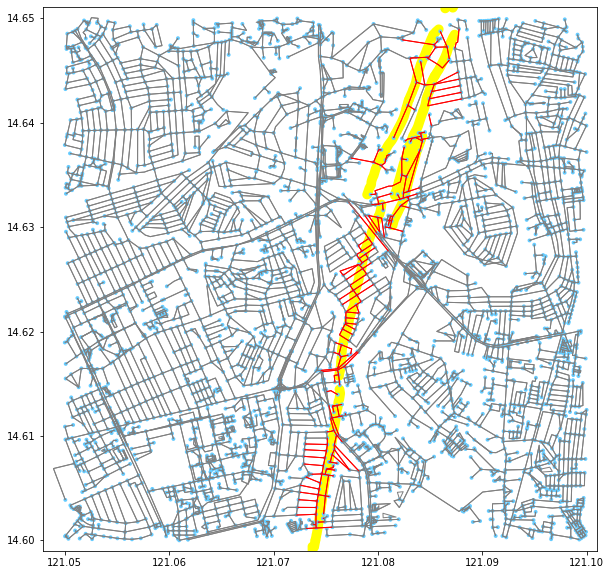

<Figure size 432x288 with 0 Axes>

In [30]:
G_clip_fault.graph.update( {'crs' : crs_global} )
G_clip_fault.graph.update( {'name' : 'manila'} )
nc = ['red' if data['intersects_faultline']==1 else 'grey' for u, v, data in G_clip_fault.edges(data=True)]
fig, ax = ox.plot_graph(G_clip_fault, fig_height=10, axis_off=False, show=False, edge_color=nc)
faultline.plot(ax=ax, color='yellow', zorder=0)
fig

In [ ]:
disrupt_network_edges - set to fail value

- create new time value based on 

In [ ]:
def disrupt_network_edges(G, property, thresh, fail_value):
    """
    Function for disrupting a graph given a threshold value against an edge's property
    Any edges which bind to broken nodes have their 'time' property set to fail_value
    :param G: REQUIRED a graph containing one or more nodes and one or more edges
    :param property: the element in the data dictionary for the edges to test
    :param thresh: values of data[property] above this value are disrupted
    :param fail_value: The data['time'] property is set to this value to simulate the removal of the edge
    :returns: a modified graph with the edited 'time' attribute
    """
    G_copy = G.copy()

    broken_nodes = []

    for u, data in G_copy.nodes(data = True):

        if data[property] > thresh:

            broken_nodes.append(u)

    print('nodes disrupted: %s' % len(broken_nodes))
    i = 0
    for u, v, data in G_copy.edges(data = True):

        if u in broken_nodes or v in broken_nodes:

            data['time'] = fail_value
            i+=1

    print('edges disrupted: %s' % i)
    return G_copy

In [ ]:
def disrupt_network(G, property, thresh, fail_value):
    """
    Function for disrupting a graph given a threshold value against a node's value. Any edges which bind to broken nodes have their 'time' property set to fail_value
    :param G: REQUIRED a graph containing one or more nodes and one or more edges
    :param property: the element in the data dictionary for the edges to test
    :param thresh: values of data[property] above this value are disrupted
    :param fail_value: The data['time'] property is set to this value to simulate the removal of the edge
    :returns: a modified graph with the edited 'time' attribute
    """
    G_copy = G.copy()

    broken_nodes = []

    for u, data in G_copy.nodes(data = True):

        if data[property] > thresh:

            broken_nodes.append(u)

    print('nodes disrupted: %s' % len(broken_nodes))
    i = 0
    for u, v, data in G_copy.edges(data = True):

        if u in broken_nodes or v in broken_nodes:

            data['time'] = fail_value
            i+=1

    print('edges disrupted: %s' % i)
    return G_copy

In [ ]:
disruption function based on edges

In [29]:
G_disrupt = gn.disrupt_network(G_faultline, "intersects_liquefaction", 0.5, 4.5)

#wrong application - this sets distance instead of speed to 4.5

nodes disrupted: 1501
edges disrupted: 4044


In [32]:
gn.save(G_disrupt,'manila_clean_clipped_disrupted','data_osm_raw')

In [12]:
cd ..

/home/op


In [15]:
G_disrupt = nx.read_gpickle('data_osm_raw/manila_clean_clipped_disrupted.pickle')

In [ ]:
potential solution: generate new column time_disrupted which is very high if in faultline and 
    increased by some factor/set to walking speed when in liqeufaction area 

In [16]:
G_disrupt.edges(data=True)

OutMultiEdgeDataView([(0, 123, {'Wkt': 'LINESTRING (121.0648473 14.6146113, 121.064523 14.6144786)', 'id': 134068, 'infra_type': 'service', 'osm_id': '668513268', 'key': 'edge_134068', 'length': 37.89835123465312, 'Type': 'legitimate', 'length_m': 37.89835123465312, 'time': 6.821703222237561, 'mode': 'drive'}), (1, 143, {'Wkt': 'LINESTRING (121.0630569 14.6059593, 121.0630113 14.6059872, 121.0629838 14.6059931, 121.0629342 14.6059872, 121.062902 14.6059717, 121.0628778 14.6059509, 121.0628628 14.6059244)', 'id': 119215, 'infra_type': 'service', 'osm_id': '566978154', 'key': 'edge_119215', 'length': 24.91530363261625, 'Type': 'legitimate', 'length_m': 24.91530363261625, 'time': 4.484754653870925, 'mode': 'drive'}), (1, 1404, {'Wkt': 'LINESTRING (121.0628628 14.6059244, 121.062851 14.605899, 121.0627898 14.6056962)', 'id': 119216, 'infra_type': 'service', 'osm_id': '566978154', 'key': 'edge_119216', 'length': 26.47109149796716, 'Type': 'legitimate', 'length_m': 26.47109149796716, 'time':

disruption in GN is working based on whether nodes are in field of disaster -
this is bad if long edges without nodes lead through disaster fields, as these will not be affected. 
one solution to this is the salt long lines option


for ground liquefaction we want to slow everything down - could use approach similar to this: 
    https://github.com/worldbank/GOST_PublicGoods/blob/master/Implementations/SierraLeone%20-%20GOSTnets/Step%204.a%20-%20Generate%20Flooding%20Version%20of%20Graph.ipynb

In [ ]:

def disrupt_network(G, property, thresh, fail_value):
    """
    Function for disrupting a graph given a threshold value against a node's value. 
    Any edges which bind to broken nodes have their 'time' property set to fail_value


## od matrices

In [ ]:
project graph
convert to time

In [39]:
gn.example_node(G)

(0, {'x': 121.032836, 'y': 14.566063})


In [40]:
gn.example_edge(G)

(0, 19650, {'Wkt': 'LINESTRING (121.032836 14.566063, 121.033509 14.5655514)', 'id': 18962, 'infra_type': 'residential', 'osm_id': '23006710', 'key': 'edge_18962', 'length': 0.0920008330049905, 'Type': 'legitimate'})


In [ ]:
disruptio

gn bugs

- function graph_edges_intersecting_polygon(G, polygons, mode, crs = None, fast = True) specifies moode= 'intersecting' as param, but checks for 'intersects'

- function clip doesn't work because shapely isn't imported 
- function clip doesn't work with new networkx